# MTA Project 01

Using the MTA turnstile data for the past four months to analyze foot traffic in conjuction with liquor license determinations per area to determine the density of bar locations to foot traffic in order to identify the ideal locations for least competition and great foot traffic.

## Read Data to Dataframe

In [4]:
import pandas as pd
import numpy as np

In [5]:
# Import data
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [181201, 181208, 181215, 181222, 181229,
             190105, 190112, 190119, 190126, 
             190202, 190209, 190216, 190223,
             190302, 190309, 190316, 190323, 190330]
turnstiles_df = get_data(week_nums)
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,03:00:00,REGULAR,6845468,2321627
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,07:00:00,RECOVR AUD,6845479,2321635
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,11:00:00,RECOVR AUD,6845578,2321702
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,15:00:00,RECOVR AUD,6845780,2321753
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/24/2018,19:00:00,REGULAR,6846083,2321818


## Clean Data (Part 1)

In [6]:
# Remove duplicate entries
turnstiles_df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'], inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'], inplace=True)

In [7]:
# Convert date to datetime
turnstiles_df['DATE'] = pd.to_datetime(turnstiles_df['DATE'], format='%m/%d/%Y')
turnstiles_df.dtypes

C/A                                                                             object
UNIT                                                                            object
SCP                                                                             object
STATION                                                                         object
LINENAME                                                                        object
DIVISION                                                                        object
DATE                                                                    datetime64[ns]
TIME                                                                            object
DESC                                                                            object
ENTRIES                                                                          int64
EXITS                                                                            int64
dtype: object

In [8]:
# Test for duplicate counts
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)
 ['ENTRIES']).nunique()

1

## Calculate Entries per Day

In [9]:
# Get entries per day
entries_df = \
    (turnstiles_df.sort_values(by=['TIME'], ascending=False)
                  .groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE'], as_index=False)
                  ['ENTRIES']
                  .first())

entries_df['DAILY_ENTRIES'] = (entries_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME'])
                                         ['ENTRIES']
                                         .diff()
                                         .shift(-1))

entries_df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,2018-11-24,6846261,740.0
1,A002,R051,02-00-00,59 ST,NQR456W,2018-11-25,6847001,1386.0
2,A002,R051,02-00-00,59 ST,NQR456W,2018-11-26,6848387,1426.0
3,A002,R051,02-00-00,59 ST,NQR456W,2018-11-27,6849813,1420.0
4,A002,R051,02-00-00,59 ST,NQR456W,2018-11-28,6851233,1537.0


## Clean Data (Part 2)

In [10]:
# Invert neagative numbers and outliers
entries_df['DAILY_ENTRIES'] = entries_df['DAILY_ENTRIES'].abs()
entries_df[entries_df['DAILY_ENTRIES'] > 8000] = np.nan

## Combine Station and Linename into a Single Variable (where necessary)

In [11]:
separate_stations = ['23 ST', '86 ST']
df1 = entries_df[entries_df['STATION'].isin(separate_stations)]
df1['STATION_LINE'] = df1['STATION'] + ' ' + df1['LINENAME']
df1.head()

/Users/christianbranton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,DAILY_ENTRIES,STATION_LINE
11989,A030,R083,01-00-00,23 ST,NRW,2018-11-24,6931107.0,1050.0,23 ST NRW
11990,A030,R083,01-00-00,23 ST,NRW,2018-11-25,6932157.0,2247.0,23 ST NRW
11991,A030,R083,01-00-00,23 ST,NRW,2018-11-26,6934404.0,2375.0,23 ST NRW
11992,A030,R083,01-00-00,23 ST,NRW,2018-11-27,6936779.0,2443.0,23 ST NRW
11993,A030,R083,01-00-00,23 ST,NRW,2018-11-28,6939222.0,2435.0,23 ST NRW


In [12]:
df2 = entries_df[~entries_df.STATION.isin(separate_stations)]
df2['STATION_LINE'] = df2['STATION']
df2.head()

/Users/christianbranton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,DAILY_ENTRIES,STATION_LINE
0,A002,R051,02-00-00,59 ST,NQR456W,2018-11-24,6846261.0,740.0,59 ST
1,A002,R051,02-00-00,59 ST,NQR456W,2018-11-25,6847001.0,1386.0,59 ST
2,A002,R051,02-00-00,59 ST,NQR456W,2018-11-26,6848387.0,1426.0,59 ST
3,A002,R051,02-00-00,59 ST,NQR456W,2018-11-27,6849813.0,1420.0,59 ST
4,A002,R051,02-00-00,59 ST,NQR456W,2018-11-28,6851233.0,1537.0,59 ST


In [13]:
entries_df = pd.concat([df1, df2], axis=0)
entries_df.sample(10)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,DAILY_ENTRIES,STATION_LINE
520028,R402,R446,00-00-02,BROOK AV,6,2019-02-15,5272687.0,630.0,BROOK AV
401967,R138,R293,00-02-02,34 ST-PENN STA,123ACE,2019-01-23,9678817.0,2313.0,34 ST-PENN STA
44157,B016,R098,00-03-01,CHURCH AV,BQ,2019-01-06,1159496.0,2149.0,CHURCH AV
532326,R422,R428,00-00-01,BUHRE AV,6,2019-01-08,2918173.0,768.0,BUHRE AV
335378,PTH01,R549,00-01-01,NEWARK HW BMEBE,1,2019-02-02,8063.0,0.0,NEWARK HW BMEBE
439393,R200A,R041,01-00-04,BOWLING GREEN,45,2018-12-14,14617354.0,543.0,BOWLING GREEN
427831,R173,R159,00-00-01,116 ST-COLUMBIA,1,2019-03-27,11689879.0,2765.0,116 ST-COLUMBIA
157545,N070,R012,04-00-02,34 ST-PENN STA,ACE,2019-03-04,9146840.0,1075.0,34 ST-PENN STA
85738,G001,R151,00-03-02,CONEY IS-STILLW,DFNQ,2018-11-28,196906.0,183.0,CONEY IS-STILLW
227895,N305,R017,01-03-03,LEXINGTON AV/53,EM6,2019-01-14,12349028.0,1697.0,LEXINGTON AV/53


## Get Top *N* Busiest Stations

In [40]:
# Get total entries per day by station
top_count = 50
per_station = (entries_df.groupby(['STATION_LINE'], as_index=False)
                         ['DAILY_ENTRIES']
                         .sum()
                         .sort_values(by=['DAILY_ENTRIES'], ascending=False)).head(10)
tops_df = per_station.head(top_count).reset_index().drop(['index'], axis=1)
tops_df['DAILY_ENTRIES'] = tops_df['DAILY_ENTRIES'] / len(entries_df['DATE'].dropna().unique())
tops_df

,STATION_LINE,DAILY_ENTRIES
0,34 ST-PENN STA,140962.944444
1,GRD CNTRL-42 ST,123142.388889
2,34 ST-HERALD SQ,106517.166667
3,42 ST-PORT AUTH,88229.436508
4,14 ST-UNION SQ,87101.928571
5,TIMES SQ-42 ST,84867.158730
6,FULTON ST,76393.039683
7,125 ST,66145.000000
8,CANAL ST,62808.865079
9,59 ST COLUMBUS,61940.031746


## Check Data with Graphs

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

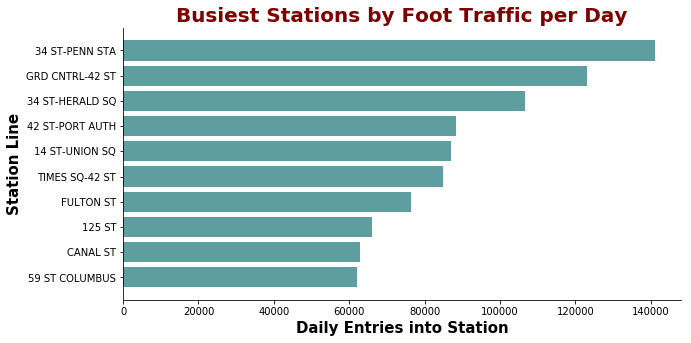

In [45]:
plt.figure(figsize=(10, 5))
tops_display_df = tops_df.sort_values(by='DAILY_ENTRIES')
plt.barh(tops_display_df['STATION_LINE'], tops_display_df['DAILY_ENTRIES'], color = 'cadetblue');
plt.title('Busiest Stations by Foot Traffic per Day', fontweight = "bold", color ='maroon', fontsize=20)
plt.xlabel('Daily Entries into Station', fontsize=15, fontweight='bold')
plt.ylabel('Station Line', fontsize=15, fontweight='bold');
sns.despine()
plt.savefig('busstatfig.png', bbox_inches='tight')
#%config InlineBackend.figure_format = 'svg’, or
#fig.savefig(‘busieststationfig.svg’, format=’svg’)


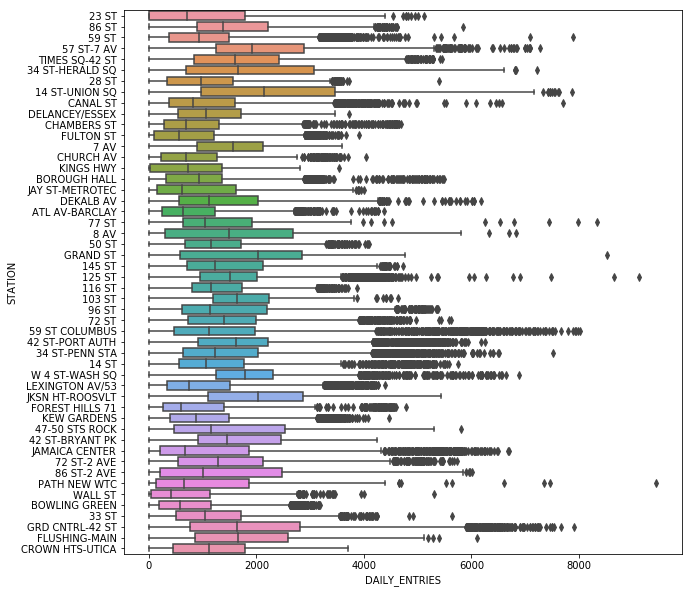

In [278]:
tops_mask = entries_df['STATION_LINE'].isin(tops_df['STATION_LINE'])
tops_daily = entries_df[tops_mask]
plt.figure(figsize=(10, 10))
sns.boxplot('DAILY_ENTRIES', 'STATION', data=tops_daily);

## Format Station Names for Lat/Long Dataframe

In [279]:
latlong_df = pd.read_csv('https://data.ny.gov/api/views/i9wp-a4ja/rows.csv?accessType=DOWNLOAD')

In [280]:
latlong_df.columns

Index(['Division', 'Line', 'Station Name', 'Station Latitude',
       'Station Longitude', 'Route1', 'Route2', 'Route3', 'Route4', 'Route5',
       'Route6', 'Route7', 'Route8', 'Route9', 'Route10', 'Route11',
       'Entrance Type', 'Entry', 'Exit Only', 'Vending', 'Staffing',
       'Staff Hours', 'ADA', 'ADA Notes', 'Free Crossover',
       'North South Street', 'East West Street', 'Corner', 'Entrance Latitude',
       'Entrance Longitude', 'Station Location', 'Entrance Location'],
      dtype='object')

In [281]:
latlong_df['Lines'] = ''
for x in range(1, 12):
    latlong_df['Lines'] += latlong_df[f'Route{x}'].fillna('').astype(str)
latlong_df.sample(5)

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,...,ADA Notes,Free Crossover,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location,Lines
380,IND,Archer Av,Parsons Blvd-Archer Av - Jamaica Center,40.702147,-73.801109,E,J,Z,NaN,NaN,...,NaN,True,Parsons Blvd,Archer Ave,NE,40.702821,-73.799843,"(40.702147, -73.801109)","(40.702821, -73.799843)",EJZ
554,BMT,Broadway,Whitehall St,40.703087,-74.012994,R,1,NaN,NaN,NaN,...,NaN,True,NaN,NaN,NaN,40.704015,-74.013284,"(40.703087, -74.012994)","(40.704015, -74.013284)",R1
462,BMT,Broadway,23rd St,40.741303,-73.989344,N,R,NaN,NaN,NaN,...,NaN,False,Broadway,23rd St,NW,40.741913,-73.989428,"(40.741303, -73.989344)","(40.741913, -73.989428)",NR
1262,IRT,Lenox,125th St,40.807754,-73.945495,2,3,NaN,NaN,NaN,...,NaN,False,Lenox Ave,125th St,SE,40.807548,-73.945463,"(40.807754, -73.945495)","(40.807548, -73.945463)",23
1376,IRT,Lexington,Bowling Green,40.704817,-74.014065,4,5,NaN,NaN,NaN,...,NaN,True,Broadway,Battery Pl,NW,40.704825,-74.014572,"(40.704817, -74.014065)","(40.704825, -74.014572)",45


## Merge MTA Turnstile and Station Info Dataframes

In [202]:
latlong_names_df = pd.read_csv('latlong_names.csv')
latlong_names_df['STATION_LINE'].value_counts().head(5)

BEVERLEY ROAD    1
14TH STREET 1    1
57 ST-7 AV       1
9 AV             1
NEREID AV        1
Name: STATION_LINE, dtype: int64

In [204]:
all_mta_df = tops_df.merge(latlong_names_df, on='STATION_LINE', how='left')
#all_mta_df

In [205]:
latlong_means_df = latlong_df.groupby(['Station Name'])['Station Latitude', 'Station Longitude'].mean()
all_mta_df = all_mta_df.merge(latlong_means_df, left_on='LL_NAME', right_on='Station Name', how='left')
all_mta_df

,STATION_LINE,DAILY_ENTRIES,LL_NAME,Station Latitude,Station Longitude
0,34 ST-PENN STA,17705633.0,34th St,40.750882,-73.990876
1,GRD CNTRL-42 ST,15472550.0,Grand Central-42nd St,40.751738,-73.976758
2,34 ST-HERALD SQ,13377929.0,34th St,40.750882,-73.990876
3,42 ST-PORT AUTH,11061713.0,42nd St,40.755765,-73.987152
4,14 ST-UNION SQ,10936479.0,14th St-Union Square,40.734673,-73.989951
5,TIMES SQ-42 ST,10641226.0,Times Square,40.755359,-73.987368
6,FULTON ST,9595345.0,Fulton St,40.707411,-74.004122
7,125 ST,8301242.0,125th St,40.809510,-73.948289
8,CANAL ST,7880639.0,Canal St,40.720309,-74.003088
9,59 ST COLUMBUS,7770388.0,59th St,40.736216,-73.986555


## Write out .csv

In [206]:
all_mta_df.to_csv('mta_busiest_latlong.csv')